Practice Exercises: 

In [193]:
import torch
from matplotlib import pyplot as plt
import random

1.   We construct an artificial dataset according to a linear model
( w = [2, − 3.4]⊤ and b = 4.2 ) with normal distributed noise. 
2.   1000 examples with 2 features sampled from standard normal distribution.



In [194]:
def synthetic_data(w, b, num_examples):
  """Generate y = Xw + b + noise"""
  X = torch.normal(0, 0.01, (num_examples, len(w)))
  y = torch.matmul(X, w) + b 
  y += torch.normal(0, 0.01, y.shape)
  return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2

features, labels = synthetic_data(true_w, true_b, 1000)

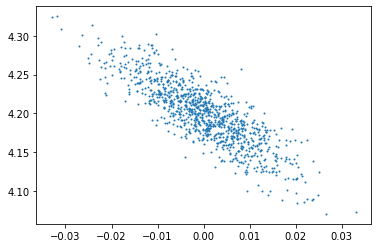

In [195]:
# Scatter plot of the 2nd feature features[:, 1] and labels.
plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)
plt.show()

# We observe linear correlation between input and output.

# Linear Regression 
### Linear Regression Model

To calculate the output of the linear model,
we simply take the matrix-vector dot product
of the input features $\mathbf{X}$ and the model weights $\mathbf{w}$,
and add the offset $b$ to each example.
Note that below $\mathbf{Xw}$  is a vector and $b$ is a scalar.
Recall the broadcasting mechanism as described in chapter 2.
When we add a vector and a scalar,
the scalar is added to each component of the vector.

In [196]:
# set up the model
def linreg(X, w, b):
  """The linear regression model"""
  return torch.matmul(X, w) + b

### Loss Function

Before we start thinking about how to fit data with our model, we need to determine a measure of fitness.
The loss function quantifies the distance between the real and predicted value of the target.
The loss will usually be a non-negative number where smaller values are better and perfect predictions incur a loss of `0`.
The most popular loss function in regression problems is the squared error. 

Here we will implement the squared loss function in PyTorch.
In the implementation, we first need to transform the true value `y` into the predicted value’s shape `y_hat` and compute the squared of the difference with the predicted value. The result returned by the function will also have the same shape as `y_hat`.

In [197]:
# create the loss function: to determinde the measure of fitness, the most popular loss function in linear regression model is the squared error
def squared_loss(y_hat, y):
  """Squared loss."""
  return (y_hat - y.reshape(y_hat.shape))**2 / 2 


### Stochastic Gradient Descent

The following code applies the stochastic gradient descent update, given a set of parameters, a learning rate, and a batch size.
At each step, using one minibatch randomly drawn from our dataset, we will estimate the gradient of the loss with respect to our parameters. Next, we will update our parameters in the direction that may reduce the loss. The size of the update step is determined by the learning rate `lr`. 
Because our loss is calculated as a sum over the minibatch of examples, we normalize our step size by the batch size, so that the magnitude of a typical step size does not depend heavily on our choice of the batch size.

In [198]:
def sgd(params, lr, batch_size):
  """Minibatch stochastic gradient descent"""
  with torch.no_grad():
    for param in params:
      param -= lr * param.grad / batch_size
      param.grad.zero_()

### Reading Dataset

In the following code, we define the data_iter function to demonstrate a functtion shuffle the dataset and access it in minibatches.
The function takes a batch size, a matrix of features, and a vector of labels, yielding minibatches of the size batch_size. Each minibatch consists of a tuple of features and labels.

In [199]:
def data_iter(batch_size, features, labels): 
  num_examples = len(features)
  indices = list(range(num_examples))
  
  # the examples are read at random, in no particular order
  random.shuffle(indices)

  for i in range(0, num_examples, batch_size):
    batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
    yield features[batch_indices], labels[batch_indices]

### Model Initialization

Before we can begin optimizing our model’s parameters to best fit the our training dataset, we need to have some parameters in the first place.
We cannot initialize all weights to the value `0.0`.
Initializing all the weights with zeros leads the neurons to learn the same features during training.
In the following code, we initialize weights by sampling random numbers from a normal distribution with mean `0` and a standard deviation of `0.01`, and setting the bias to `0`.

In [200]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### Model Training

In each epoch, we will iterate through the entire dataset once passing through every example in the training dataset.
In each iteration, we will grab a minibatch of training examples using the data_iter function we created in the last slide.
We the pass the mini batch training examples through our model to obtain a set of predictions. We then compute the loss using the squared_loss function we had implemented earlier. Next we initiate the backwards function to instruct PyTorch to store the gradients of the loss with respect to each parameter.  Finally, we will call the optimization algorithm sgd to update the model parameters.



In [201]:
lr = 0.01
num_epochs = 3
batch_size = 11

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = squared_loss(linreg(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = squared_loss(linreg(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 1.418756
epoch 2, loss 0.229242
epoch 3, loss 0.037544


# Single Layer Neural Network

### Neural Network Model

In PyTorch, the fully-connected layer is defined in the `Linear` class.
Note that we passed two arguments into `nn.Linear`. The first one specifies the input feature dimension, which is `2`.
and the second one is the output feature dimension, which is a single scalar and therefore `1`.

We then define a model variable `net`, which will refer to an instance of the `Sequential` class. The `Sequential` class defines a container for several layers that will be chained together. 

In [202]:
from torch import nn 
from torch.utils import data


# model name

net = nn.Linear(2,1)

### Neural Network Loss

The `MSELoss` class from PyTorch computes the mean squared error between each element in the prediction and target.
Mean squared error is also sometimes referred to squared L2 norm.
By default it returns the average loss over examples.

In [203]:
loss = nn.MSELoss()

### Neural Network Optimization

Stochastic gradient descent or SGD for short is a standard tool for optimizing neural networks and thus PyTorch supports it alongside a number of variations on this algorithm in the `optim` module.
When we instantiate an SGD instance, we will specify the parameters to optimize over, and which hyperparameters are required by our optimization algorithm. 
Function `net.parameters()` returns the neural network parameters. Stochastic gradient descent just requires that we set the value learning rate `lr`, which is set to `0.03` here.




In [204]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.03)

### Reading Dataset

Rather than creating our own iterator, we can call upon the existing API in a framework to read data.
We pass in features and labels as arguments and specify `batch_size` when instantiating a data iterator object. Besides, the boolean value `is_train` indicates whether or not we want the data iterator object to shuffle the data on each epoch.
Now we can use `data_iter` in much the same way as we called the `data_iter` function in the linear regression section.

### Neural Network Model Initialization

Before using net, we need to initialize the model parameters, such as the weights and bias in the linear regression model.
Deep learning frameworks like PyTorch often have a predefined way to initialize the parameters.
Here we specify that each weight parameter should be randomly sampled from a normal distribution with mean `0` and standard deviation `0.01`.
The bias parameter will be initialized to zero.

In [205]:
net.weight.data.normal_(0, 0.01)
net.bias.data.fill_(0)

tensor([0.])

## Essential Step:

### Neural Network Model Training

For some number of epochs which we fix, we will make a complete pass over the dataset, iteratively grabbing one minibatch of inputs and the corresponding ground-truth labels.

For each minibatch, we go through the following steps:
* Generate predictions by calling `net(X)` and calculate the loss `l` .
* Calculate gradients by calling the `l.backward()` function. This step is what is commonly know as the backpropagation step.
* Update the model parameters by invoking our `optimizer`.

In [206]:
num_epochs = 10

for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    l = loss(net(X), y)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

  l = loss(net(features), labels)
  print(f'epoch {epoch + 1}, loss { l:f}')

epoch 1, loss 0.001843
epoch 2, loss 0.001632
epoch 3, loss 0.001634
epoch 4, loss 0.001631
epoch 5, loss 0.001633
epoch 6, loss 0.001629
epoch 7, loss 0.001631
epoch 8, loss 0.001625
epoch 9, loss 0.001621
epoch 10, loss 0.001620


In [207]:
# if we do not implimnet optimizer.zero_grad(), our loss will be much larger. As well as the optimizer.step(). 